In [353]:
import pandas as pd
import numpy as np 
# データ可視化のライブラリ
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
# 機械学習ライブラリ
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score # 正答率見るやつ
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)
from sklearn.metrics import log_loss # モデル評価用(logloss) 
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
# LightGBM関連
import lightgbm as lgb
import japanize_matplotlib
import scipy
from numpy.random import randn #正規乱数
# graphvizのインポート
import graphviz
#grid searchとcross validation用
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [343]:
# CSVファイルの読み込み。2017-2019の２年分
df = pd.read_csv('usdjpy_d_2010-2021_2.csv')
# 最後の5行を確認
df.tail()

,time,close,open,high,low,volume
2892,2021/3/3,107.009,106.703,107.153,106.700,100000
2893,2021/3/4,107.977,107.007,107.997,106.969,100000
2894,2021/3/5,108.351,107.976,108.636,107.821,100000
2895,2021/3/8,108.930,108.382,108.943,108.310,100000
2896,2021/3/9,108.522,108.924,109.233,108.417,100000


In [344]:
# 翌日終値 - 当日終値で差分を計算
#shift(-1)でcloseを上に1つずらす
df['close+1'] = df.close.shift(-1)
df['diff'] = df['close+1'] - df['close']
# 最終日はclose+1がNaNになるので削る
df = df[:-1]
# close+1を追加して翌日と比較
df.tail()

,time,close,open,high,low,volume,close+1,diff
2891,2021/3/2,106.704,106.776,106.957,106.679,100000,107.009,0.305
2892,2021/3/3,107.009,106.703,107.153,106.700,100000,107.977,0.968
2893,2021/3/4,107.977,107.007,107.997,106.969,100000,108.351,0.374
2894,2021/3/5,108.351,107.976,108.636,107.821,100000,108.930,0.579
2895,2021/3/8,108.930,108.382,108.943,108.310,100000,108.522,-0.408


In [345]:
# 上昇と下降のデータ割合を確認
m = len(df['close'])
# df['diff']>0で全行に対してtrueかfalseで返してくれる。df[(df['diff'] > 0)]でdff>0に絞って全てのカラムを出力
#上昇した日の割合
print(len(df[(df['diff'] > 0)]) / m * 100)
# 下降した日の割合
print(len(df[(df['diff'] < 0)]) / m * 100)

49.620165745856355
50.03453038674033


In [346]:
df.rename(columns={"diff" : "target"}, inplace=True)

# 不要なカラムを削除
del df['close+1']
del df['time']
# カラムの並び替え
df = df[['target', 'volume', 'open', 'high', 'low', 'close']]
# 最初の5行を出力
df.head()

,target,volume,open,high,low,close
0,-0.68,100000,92.914,93.20,92.18,92.40
1,0.62,100000,92.410,92.53,91.25,91.72
2,1.25,100000,91.710,92.73,91.52,92.34
3,-0.94,100000,92.340,93.75,92.10,93.59
4,-0.60,100000,93.580,93.66,92.28,92.65


In [347]:
df.loc[df['target'] > 0, "target"] = 1
df.loc[df['target'] < 0, "target"] = 0
# 最初の5行を出力
df.head()

,target,volume,open,high,low,close
0,0.0,100000,92.914,93.20,92.18,92.40
1,1.0,100000,92.410,92.53,91.25,91.72
2,1.0,100000,91.710,92.73,91.52,92.34
3,0.0,100000,92.340,93.75,92.10,93.59
4,0.0,100000,93.580,93.66,92.28,92.65


In [348]:
#移動平均の計算、5日、25日、50日、75日
#ついでにstdも計算する。（=ボリンジャーバンドと同等の情報を持ってる）
#75日分のデータ確保
for i in range(1, 75):
    df['close-'+str(i)] = df.close.shift(+i)
#移動平均の値とstdを計算する, skipnaの設定で一つでもNanがあるやつはNanを返すようにする
nclose = 5    
df['MA5'] = df.iloc[:, np.arange(nclose, nclose+5)].mean(axis='columns', skipna=False)
df['MA25'] = df.iloc[:, np.arange(nclose, nclose+25)].mean(axis='columns', skipna=False)
df['MA50'] = df.iloc[:, np.arange(nclose, nclose+50)].mean(axis='columns', skipna=False)
df['MA75'] = df.iloc[:, np.arange(nclose, nclose+75)].mean(axis='columns', skipna=False)

df['STD5'] = df.iloc[:, np.arange(nclose, nclose+5)].std(axis='columns', skipna=False)
df['STD25'] = df.iloc[:, np.arange(nclose, nclose+25)].std(axis='columns', skipna=False)
df['STD50'] = df.iloc[:, np.arange(nclose, nclose+50)].std(axis='columns', skipna=False)
df['STD75'] = df.iloc[:, np.arange(nclose, nclose+75)].std(axis='columns', skipna=False)
#計算終わったら余分な列は削除
for i in range(1, 75):
    del df['close-'+str(i)]
#それぞれの平均線の前日からの変化（移動平均線が上向か、下向きかわかる）
#shift(-1)でcloseを上に1つずらす
df['diff_MA5'] = df['MA5'] - df.MA5.shift(1) 
df['diff_MA25'] = df['MA25'] - df.MA25.shift(1) 
df['diff_MA50'] = df['MA50'] - df.MA50.shift(1) 
df['diff_MA75'] = df['MA50'] - df.MA50.shift(1) 
#3日前までのopen, close, high, lowも素性に加えたい
for i in range(1, 4):
    df['close-'+str(i)] = df.close.shift(+i)
    df['open-'+str(i)] = df.open.shift(+i)
    df['high-'+str(i)] = df.high.shift(+i)
    df['low-'+str(i)] = df.low.shift(+i)

#NaNを含む行を削除
df = df.dropna()
#何日分使うか決める
nday = 500
df = df[-nday:]

del df['volume'] # いらないので削除
df.head()
df

,target,open,high,low,close,MA5,MA25,MA50,MA75,STD5,...,high-1,low-1,close-2,open-2,high-2,low-2,close-3,open-3,high-3,low-3
2396,0.0,110.947,111.444,110.816,111.410,110.7880,111.13020,110.57814,110.334027,0.375113,...,110.948,110.540,110.657,110.491,110.8320,110.021,110.492,110.529,110.7100,110.236
2397,1.0,111.412,111.456,111.251,111.334,110.9490,111.16080,110.61804,110.306587,0.407513,...,111.444,110.816,110.852,110.658,110.9480,110.540,110.657,110.491,110.8320,110.021
2398,1.0,111.332,111.575,111.209,111.464,111.1434,111.18136,110.65606,110.288427,0.364584,...,111.456,111.251,111.410,110.947,111.4440,110.816,110.852,110.658,110.9480,110.540
2399,1.0,111.456,111.678,111.336,111.616,111.3352,111.19080,110.69680,110.276853,0.289187,...,111.575,111.209,111.334,111.412,111.4560,111.251,111.410,110.947,111.4440,110.816
2400,0.0,111.617,111.820,111.564,111.678,111.5004,111.17880,110.74002,110.266933,0.143258,...,111.678,111.336,111.464,111.332,111.5750,111.209,111.334,111.412,111.4560,111.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,1.0,106.776,106.957,106.679,106.704,106.4392,105.36424,104.48746,104.344540,0.376767,...,106.889,106.367,106.598,106.250,106.6925,105.853,106.246,105.874,106.3980,105.846
2892,1.0,106.703,107.153,106.700,107.009,106.6666,105.48160,104.56082,104.376860,0.279381,...,106.957,106.679,106.776,106.553,106.8890,106.367,106.598,106.250,106.6925,105.853
2893,1.0,107.007,107.997,106.969,107.977,107.0128,105.63152,104.64788,104.427313,0.559729,...,107.153,106.700,106.704,106.776,106.9570,106.679,106.776,106.553,106.8890,106.367
2894,1.0,107.976,108.636,107.821,108.351,107.3634,105.77552,104.74402,104.487567,0.751217,...,107.997,106.969,107.009,106.703,107.1530,106.700,106.704,106.776,106.9570,106.679


In [349]:
# データの確認
# トレーニングデータ,テストデータの分割
print(df.shape) # データサイズの確認(データ数,特徴量数(変数の個数))
display(df) # df.head()に同じ(文中に入れるときはdisplay()を使う)

# 説明変数,目的変数
X = df.drop('target',axis=1) # 説明変数(target以外の特徴量)
y = df['target'].values # 目的変数(target)

# トレーニングデータ,テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.80, test_size=0.20, random_state=2)

(500, 29)


,target,open,high,low,close,MA5,MA25,MA50,MA75,STD5,...,high-1,low-1,close-2,open-2,high-2,low-2,close-3,open-3,high-3,low-3
2396,0.0,110.947,111.444,110.816,111.410,110.7880,111.13020,110.57814,110.334027,0.375113,...,110.948,110.540,110.657,110.491,110.8320,110.021,110.492,110.529,110.7100,110.236
2397,1.0,111.412,111.456,111.251,111.334,110.9490,111.16080,110.61804,110.306587,0.407513,...,111.444,110.816,110.852,110.658,110.9480,110.540,110.657,110.491,110.8320,110.021
2398,1.0,111.332,111.575,111.209,111.464,111.1434,111.18136,110.65606,110.288427,0.364584,...,111.456,111.251,111.410,110.947,111.4440,110.816,110.852,110.658,110.9480,110.540
2399,1.0,111.456,111.678,111.336,111.616,111.3352,111.19080,110.69680,110.276853,0.289187,...,111.575,111.209,111.334,111.412,111.4560,111.251,111.410,110.947,111.4440,110.816
2400,0.0,111.617,111.820,111.564,111.678,111.5004,111.17880,110.74002,110.266933,0.143258,...,111.678,111.336,111.464,111.332,111.5750,111.209,111.334,111.412,111.4560,111.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,1.0,106.776,106.957,106.679,106.704,106.4392,105.36424,104.48746,104.344540,0.376767,...,106.889,106.367,106.598,106.250,106.6925,105.853,106.246,105.874,106.3980,105.846
2892,1.0,106.703,107.153,106.700,107.009,106.6666,105.48160,104.56082,104.376860,0.279381,...,106.957,106.679,106.776,106.553,106.8890,106.367,106.598,106.250,106.6925,105.853
2893,1.0,107.007,107.997,106.969,107.977,107.0128,105.63152,104.64788,104.427313,0.559729,...,107.153,106.700,106.704,106.776,106.9570,106.679,106.776,106.553,106.8890,106.367
2894,1.0,107.976,108.636,107.821,108.351,107.3634,105.77552,104.74402,104.487567,0.751217,...,107.997,106.969,107.009,106.703,107.1530,106.700,106.704,106.776,106.9570,106.679


In [401]:
# LightGBMによる決定木モデルの訓練
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# モデルの学習(scikit-learn API で書いたとき)
# model = lgb.LGBMRegressor() # モデルのインスタンスの作成
# model.fit(X_train, y_train) # モデルの学習


# LightGBM parameters
lgb_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 回帰→'regression'  多分類→'multiclass'  二値分類→'binary'他には 'binary_logloss','auc'など
        'metric': {'binary_error'},# 評価指標: 誤り率(1-正答率) 
                                   #他には 'binary_logloss';大きく外すと罰則
    　　　　　　　　　　　　　　　 #'auc'；バランス重視　など
                                   #回帰なら'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
        'learning_rate': 0.01,
        'num_leaves': 25, # １つの木の最大葉数
        'min_data_in_leaf': 1,
        'num_iteration': 1000, # 1000回学習
        'verbose': 0
}

model = lgb.train(lgb_params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  num_boost_round=1000, # ブースト上限
                  early_stopping_rounds=50 # 50回ごとに検証精度改善→改善しないなら学習終了（過学習防止）
                 )

# テストデータの予測
y_pred_prob = model.predict(X_test)
# テストデータの予測 (予測クラス(0 or 1)を返す)
y_pred = np.where(y_pred_prob < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_error: 0.47
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_error: 0.45
[3]	valid_0's binary_error: 0.45
[4]	valid_0's binary_error: 0.4
[5]	valid_0's binary_error: 0.41
[6]	valid_0's binary_error: 0.39
[7]	valid_0's binary_error: 0.42
[8]	valid_0's binary_error: 0.42
[9]	valid_0's binary_error: 0.43
[10]	valid_0's binary_error: 0.43
[11]	valid_0's binary_error: 0.44
[12]	valid_0's binary_error: 0.43
[13]	valid_0's binary_error: 0.43
[14]	valid_0's binary_error: 0.45
[15]	valid_0's binary_error: 0.44
[16]	valid_0's binary_error: 0.43
[17]	valid_0's binary_error: 0.43
[18]	valid_0's binary_error: 0.43
[19]	valid_0's binary_error: 0.41
[20]	valid_0's binary_error: 0.44
[21]	valid_0's binary_error: 0.44
[22]	valid_0's binary_error: 0.44
[23]	valid_0's binary_error: 0.45
[2

In [397]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'target':y_test, 'target0_prob':1-y_pred_prob, 'target1_prob':y_pred_prob})
display(df_pred_prob)

,target,target_pred
0,0.0,1
1,0.0,1
2,0.0,0
3,1.0,1
4,0.0,1
...,...,...
95,0.0,1
96,1.0,1
97,0.0,0
98,0.0,0


,target,target0_prob,target1_prob
0,0.0,0.437828,0.562172
1,0.0,0.475567,0.524433
2,0.0,0.509233,0.490767
3,1.0,0.423304,0.576696
4,0.0,0.495655,0.504345
...,...,...,...
95,0.0,0.459357,0.540643
96,1.0,0.408724,0.591276
97,0.0,0.517137,0.482863
98,0.0,0.526949,0.473051


In [398]:
# モデル評価
# acc : 正答率
acc = accuracy_score(y_test,y_pred)
print('正答率（Acc） :', acc)

# logloss 
logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
print('logloss :', logloss)

# AUC 
auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
print('AUC :', auc) 

正答率（Acc） : 0.62
logloss : 0.6856695442455935
AUC : 0.5688478522681654


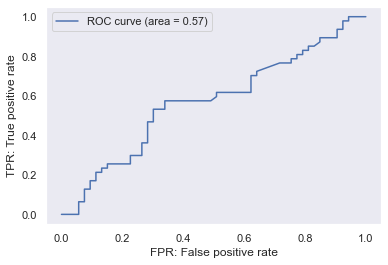

In [399]:
# ROC曲線の描画
# cf : https://tips-memo.com/python-roc
from sklearn import metrics
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

[17 33 27 36 26 44  7  0 52 41 38 71 61 58 15  0 13 45 17 52  3  8 21 62
  1 36 32 72]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

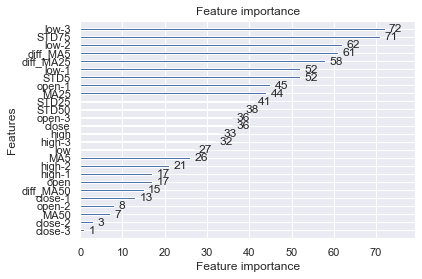

In [400]:
# 特徴量の重要度出力
print(model.feature_importance())

# 特徴量の重要度をプロット
lgb.plot_importance(model)